## <p align="center"> Clustering in ML explained! - k-means and more

Unsupervised learning is a type of machine learning in which we don't have labeled data, and instead, the goal is to find patterns or structure in the data without explicit guidance. Clustering is an unsupervised machine learning technique used to group similar objects together. The goal of using clustering algorithms is often to partition a set of observations into clusters so that observations in the same cluster are similar to each other, while observations in different clusters are dissimilar.

In this document, we'll explore various clustering techniques, including the algorithms, their advantages and limitations, and some examples of applying them to cluster datasets. Specifically, the information will be presented in the order below:

- explanation of basic k-means algorithm  
- using k-means to classify 
- explanation of k-means++ initialization
- application of k-means to image compression
- limitations of k-means clustering
- explanation of spectral clustering algorithm
- applying spectral clustering to classify non-linear data
- using RFs to compute similarity matrices (Breiman's trick) for spectral clustering

##### An explanation of basic k-mean algorithm

Before diving into the algorithm, it would be worthwhile to understand the assumptions that k-means operate under. 
These include:
- k-means assumes Euclidean space among observations, so features need to be standardized prior to running k-means
- k-means separated clusters by straight lines only
- k-means do not guaranteed to find optimal clusters
- k-means assume clusters to be continuous


With these assumptions in mind, we can now get into how the k-means algorithm works. 
1. Pick a value for k
2. Randomly choose k points in your feature space to act as your initial cluster centroids
3. Assign observations to the centroid that is closest to them using a distance metric
4. Recalculate the cluster centroids (use the average value of the observations in the cluster)
5. Repeat steps 3&4 until the cluster centroids or assignments do not change

Essentially, we want to find k non-overlapping clusters such that some measure of the inertia is minimized - usually within-clusters sum-of-squares is used. And typically, the distance function that we want to minimize,is the Euclidean distance, but other ones such as the Manhattan distance could also be used. 

Next we use our implementation of k-means and see how it works on a simulated dateset with 2 clusters. 

#####  Run the implemented version of k-means algorithm on simulated dataset with 2 clusters

In [107]:
#import packages
import time, numpy as np, pandas as pd, matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
from sklearn.datasets import make_circles

In [79]:
%run kmeans

[[-0.11556425  0.03402232]
 [ 5.12824872  5.04348765]]


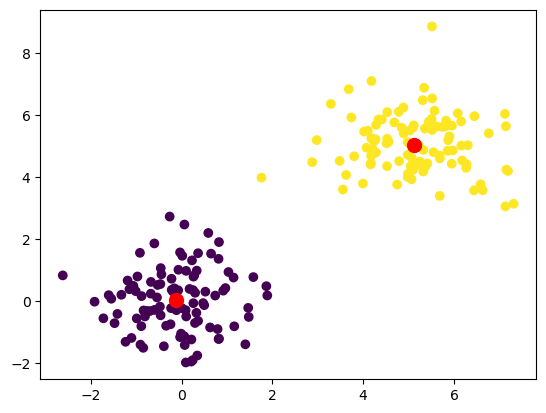

In [15]:
# Generate a simulated dataset with 2 clusters
np.random.seed(42)
X1 = np.random.normal(loc=0, scale=1, size=(100, 2))
X2 = np.random.normal(loc=5, scale=1, size=(100, 2))
X = np.concatenate([X1, X2], axis=0)

# Cluster using k-means
centroids, labels = kmeans(X, k=2, centroids=None)
print(centroids)

# Plot the results
plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis')
plt.scatter(centroids[:, 0], centroids[:, 1], s=100, c='red')
plt.show()

##### k-means++ initialization 

K-means++ is a variation of k-means that improves the initialization of the centroids. The main idea is to select the initial centroids in a way that is more likely to lead to a better final solution. It does so by choosing initial centroids that are far apart from each other, which can help to avoid getting stuck in local optima. 

The K-means++ algorithm works as follows:

1. Select the first centroid randomly from the data points.
2. For each subsequent centroid: <br>
        - Compute the distance between each data point and the nearest centroid.<br>
        - Choose the next centroid randomly with probability proportional to the square of the distance to the nearest existing centroid.
        
K-means++ is often used in practice because it tends to converge faster and produce better results than the standard K-means algorithm.

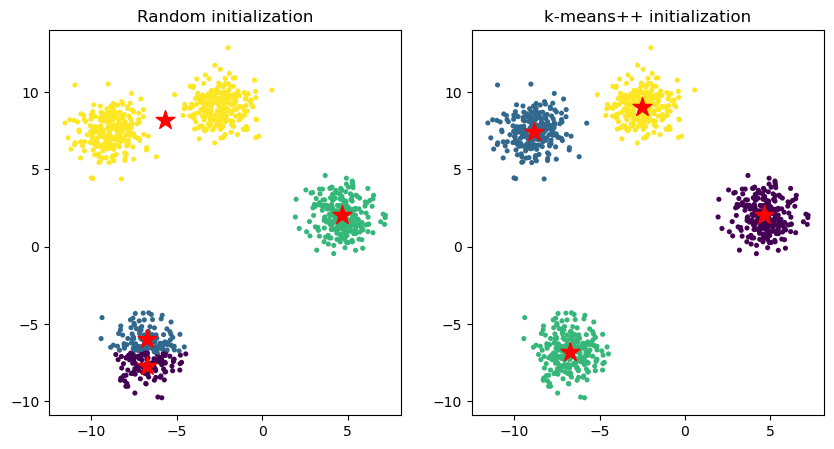

In [27]:
from sklearn.datasets import make_blobs
# Generate simulated dataset
X, y = make_blobs(n_samples=1000, centers=4, random_state=42)

# Run k-means with random initialization
centroids_rnd, labels_rnd = kmeans(X, k=4)

# Run k-means++ initialization
centroids_pp, labels_pp = kmeans(X, k=4, centroids='kmeans++')

# Plot results
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].scatter(X[:, 0], X[:, 1], c=labels_rnd, cmap='viridis', s=7)
axs[0].scatter(centroids_rnd[:, 0], centroids_rnd[:, 1], marker='*', s=200, c='red')
axs[0].set_title('Random initialization')

axs[1].scatter(X[:, 0], X[:, 1], c=labels_pp, cmap='viridis', s=7)
axs[1].scatter(centroids_pp[:, 0], centroids_pp[:, 1], marker='*', s=200, c='red')
axs[1].set_title('k-means++ initialization')

plt.show()

From the above two clustering of the same dataset, it is clear that using k-means++ results in a better solution than the basic k-means. The basic k-means cluster the bottom left cluster into two seperate groups, where clearly these points should belong to the same cluster. 

Here we run a simple time complexity analysis of the k-means algorithm we implemented. The algorithm is O(knl), where k is the number of clusters, n is the number of data points, and I is the number of iterations required for convergence.

We can see that 

n=100
n=1000
n=10000
n=100000
n=1000000
n=10000000


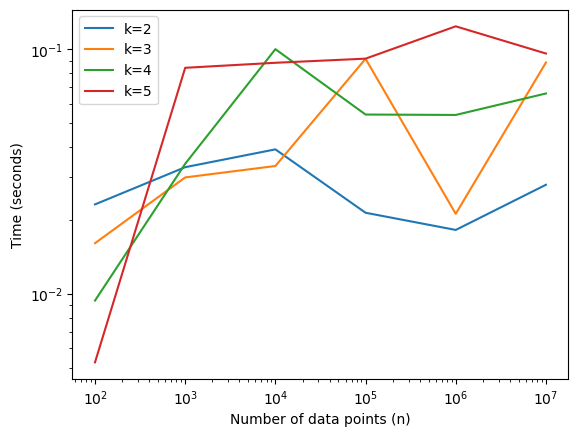

In [171]:
def plot_kmeans_time_complexity(X, max_k=10):
    """
    Plots the time complexity of k-means clustering as a function of the number of data points.

    Args:
    X (np.ndarray): Data points as an n x p numpy array
    max_k (int): Maximum number of clusters to try

    Returns:
    None
    """

    n_values = [10**i for i in range(2, 8)]
    k_values = list(range(2, max_k+1))
    times = np.zeros((len(n_values), len(k_values)))

    for i, n in enumerate(n_values):
        print(f"n={n}")
        X_subsampled = X[:n]

        for j, k in enumerate(k_values):
            start_time = time.time()
            kmeans(X_subsampled, k)
            end_time = time.time()
            times[i, j] = end_time - start_time

    for j, k in enumerate(k_values):
        plt.plot(n_values, times[:, j], label=f"k={k}")

    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('Number of data points (n)')
    plt.ylabel('Time (seconds)')
    plt.legend()
    plt.show()
    
plot_kmeans_time_complexity(X, max_k=5)

##### Application to Image Compression

Here we take a look at applying k-means clustering to image compression. One with a grayscale image, and the other on a color image. With k-means clustering, we decrease the number of colors in the image significantly. 

In [121]:
from IPython.display import Image as im
from IPython.display import display, HTML
from PIL import Image
import ipywidgets as widgets

Grayscale Image

Here we use an original [picture from North Africa](north-africa-1940s-grey.png) taken by Professor Parr's father during World War II and one with just k=4 levels of gray (takes mine 45s to compute). 

In [123]:
# Convert the image to a numpy array
X = np.asarray(img1)
h,w = X.shape
X = X.reshape((-1, 1)) 
k=4
centroids, labels = kmeans(X, k=k, centroids='kmeans++', tolerance=.01)
centroids = centroids.astype(np.uint8)
X = centroids[labels] # reassign all points

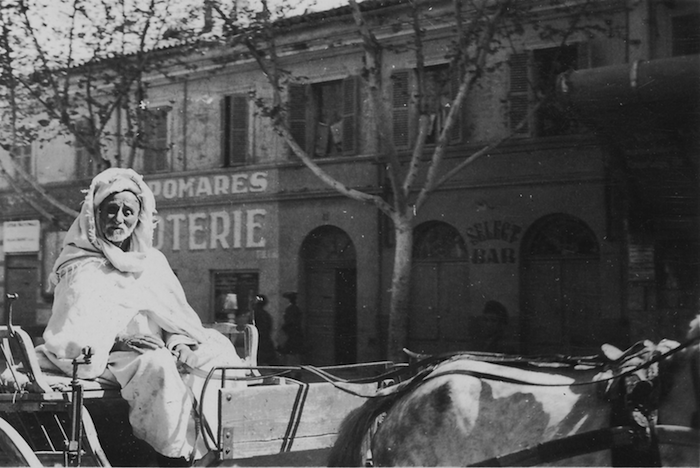

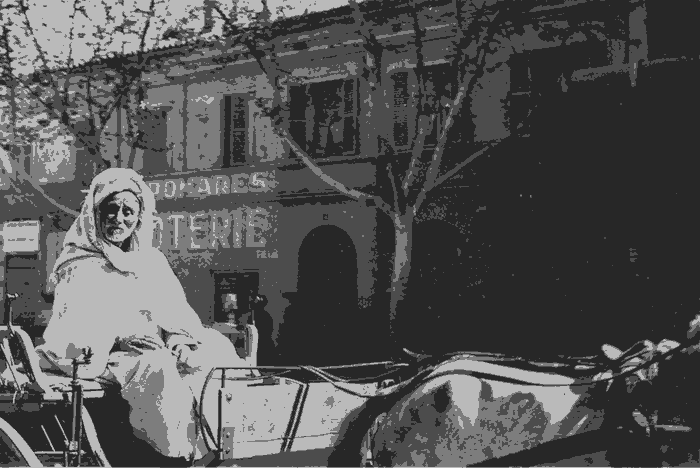

In [124]:
img2 = Image.fromarray(X.reshape(h,w), 'L')
img1 = Image.open('north-africa-1940s-grey.png')
display(img1,img2)

Color

Here is a photo of [professor parr](parrt-vancouver.jpg) in Vancouver as a disembodied head visiting Chinatown and a compressed version that uses only 32 colors. (Run in 59 seconds)

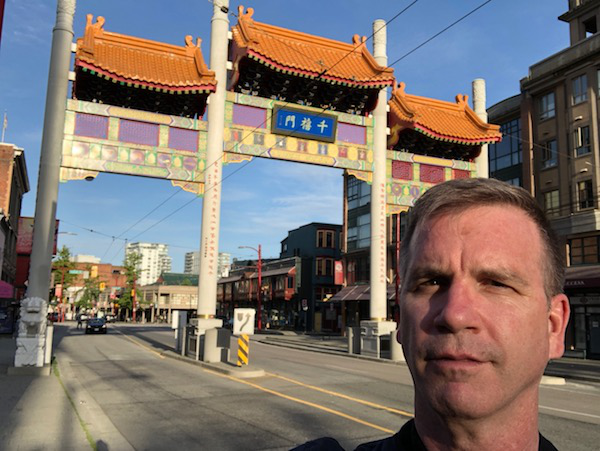

In [134]:
img = Image.open('parrt-vancouver.jpg')
display(img)

In [148]:
X = np.asarray(img)
r,g,b = X.shape
X = X.reshape((-1, 1)) 
k=32
centroids, labels = kmeans(X, k=k, centroids='kmeans++', max_iter=30)
centroids = centroids.astype(np.uint8)
X_p = centroids[labels] # reassign all points

img_ = Image.fromarray(X_p.reshape((r,g,3)))

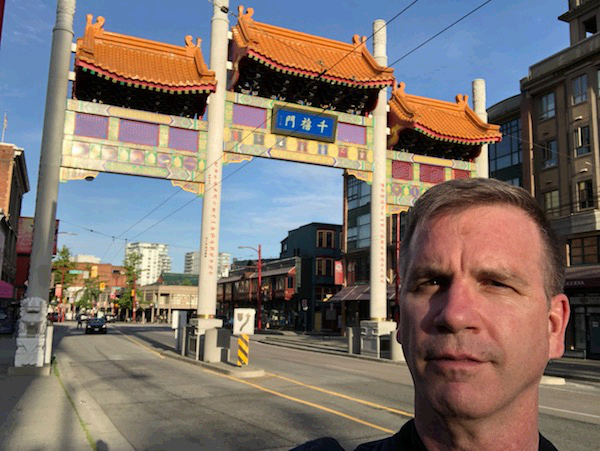

In [149]:
display(img_)

##### Problem with k-means clustering 

k-means clustering, despite being easy to implement and understand, has its own drawbacks, which that make it less suitable for certain types of data:

- It assumes that the clusters are spherical, equally sized, and have similar densities. 
- It is sensitive to the initial placement of the centroids, which can lead to local optima.
- It does not work well with data that has outliers or noise.

Below is an example of where k-means clustering fail to identify the pattern of the dataset. The two clusters here are not spherical, causing k-means to fail. 

[[-0.20579573  0.07285178]
 [ 0.63550443 -0.20553253]]


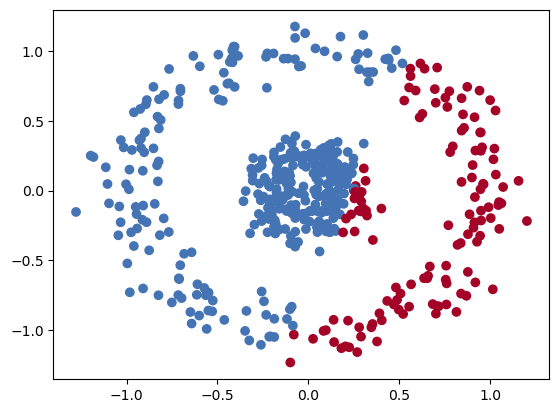

In [105]:
X, _ = make_circles(n_samples=500, noise=0.1, factor=.2)
centroids, labels = kmeans(X, 2, centroids='kmeans++')
print(centroids)
colors=np.array(['#4574B4','#A40227'])
plt.scatter(X[:,0], X[:,1], c=colors[labels])
plt.show()

##### Spectral clustering as an alternative

Spectral clustering is a more advanced clustering technique, and can be a better alternative to k-means in some cases when the data has a nonlinear structure or when the clusters are not well-separated. And spectral clustering can also be used to cluster data with different types of similarity measures (such as cosine similarity or graph Laplacian).


Here is a step by step breakdown of the spectral clustering algorithm:
1. Construct a similarity matrix (or graph) that measures the pairwise similarity between the data points.
2. Compute the Laplacian matrix of the similarity matrix.
3. Compute the eigenvectors and eigenvalues of the Laplacian matrix.
4. Select the eigenvectors corresponding to the smallest eigenvalues to represent the data in a lower-dimensional space.
5. Cluster the data points in the lower-dimensional space using a clustering algorithm (such as k-means).
6. Map the clusters back to the original space to obtain the final clustering result.


Below in the first plot, the points are mapped out in a lower-dimensional space, and we can see that there is now a clear linear structure, which we can then apply kmeans to cluster it. 

Then from the same dataset that k-means failed to cluster, spectral clustering provides a clear separation of the two clusters.

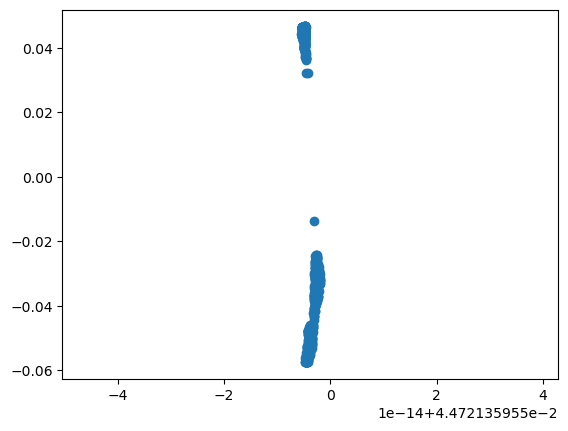

In [11]:
plt.scatter(U[:,0],U[:,1])
plt.show()

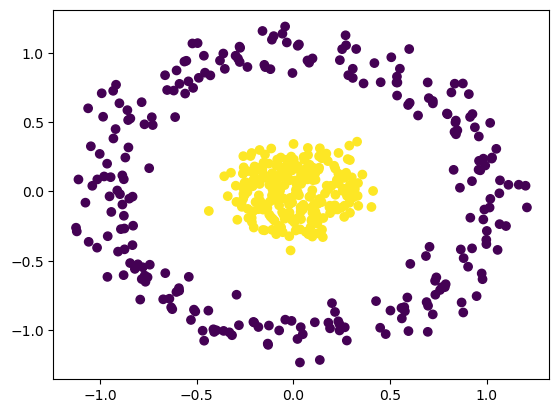

In [106]:
X, _ = make_circles(n_samples=500, noise=0.1, factor=.2)

centroids, labels = spectral_clustering(X, n_clusters=2, k=10)
plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis')
plt.show()

##### Using RFs to compute similarity matrices (Breiman's trick)

Random forests can be a useful tool for computing similarity matrices in a variety of applications including in clustering, especially when the input data is high-dimensional or nonlinear in nature. 

By training an ensemble of decision trees on a random subset of the input data and features, RFs can capture complex relationships between the input data points and produce robust similarity scores. 

The way we compute similarity measures is the following: 
1. Train a random forest on the preprocessed data
2. Use the trained RF to compute similarity matrices
    - The proximities originally formed a NxN matrix. After a tree is grown, put all of the data
    - If cases k and n are in the same terminal node increase their proximity by one
    - Repeat for all trees in random forest estimators 
    - At the end, normalize the proximities by dividing by the number of trees

Here we illustrate how this trick could be useful for spectral clustering, which compute a similarity matrix before applying the linear algebra transformation. We use RFs to compute the similarities for the sklearn cancer dataset, then we apply spectral clustering to get the labels, and generate a confusion matrix against the real labels. We compare the confusion matrix with the results from directly applying k-means clustering on the dataset. We can see they achieve similar outcomes. 

In [155]:
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler

In [ ]:
#load cancer data and applying standard scaler 
data = load_breast_cancer()
X = data.data
y = data.target

sc = StandardScaler()
X = sc.fit_transform(X)

In [169]:
S = proximity_matrix(X.astype(np.float32), y) # breiman's trick
centroids, labels  = spectral_clustering(S, n_clusters=2, k=20)
cm = confusion_matrix(1-y,labels)
df_cm = pd.DataFrame(cm, index=['Actual 0', 'Actual 1'], columns=['Predicted 0', 'Predicted 1'])
print(df_cm)

          Predicted 0  Predicted 1
Actual 0          329           28
Actual 1            2          210


In [166]:
centroids, labels  = kmeans(X, k=2, centroids='kmeans++', max_iter=30)
cm = confusion_matrix(1-y,labels)
df_cm = pd.DataFrame(cm, index=['Actual 0', 'Actual 1'], columns=['Predicted 0', 'Predicted 1'])
print(df_cm)

          Predicted 0  Predicted 1
Actual 0          341           16
Actual 1           35          177


##### Conclusion

In this report, we went through various clustering algorithms including k-means and spectral clustering, as well as some of its applications, and limitations of k-means. 

Overall, clustering algorithms are powerful tools that can help us identify patterns and relationships in large datasets. By understanding the strengths and weaknesses of each algorithm, we can choose the most appropriate one for our specific application and obtain accurate and meaningful results.